# Project - Data Mining and Text Mining

### Team members :
**Mownika Konamaneni** 

**Susmita Gopavaram**

**Bindu Lasya**

# Topic - Sentiment analysis on Twitter data

In [220]:
!pip install tensorflow-text

In [27]:
# Load libraries
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from bs4 import BeautifulSoup
import tensorflow_text as text
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mowni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Import dataset
df = pd.read_csv("D:/Masters/sem1/dataAndTextMining/twitter_data.csv", encoding = 'latin', header = None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
#Prepare data by removing unnecessary columns
df = df[[0, 5]]
df.columns = ['sentiments', 'tweet']  #labels for columns
df = df.replace([4], [1])  #replacing sentiment 4 with 1
df = df[['sentiments', 'tweet']].dropna()     #drop where NaNs present

In [5]:
df.head()

,sentiments,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [6]:
# Analysing the data

df.shape

(1600000, 2)

In [7]:
df.groupby('sentiments').describe()

tweet                                        
             count  unique                        top freq
sentiments                                                
0           800000  790185  isPlayer Has Died! Sorry   210
1           800000  793506              good morning   118

In [8]:
# # The dataset is very large, so I take .02%, Stratified sampling to balance
sampleDf = df.groupby('sentiments', group_keys=False).apply(lambda x: x.sample(frac=0.002))
ps = PorterStemmer()

In [9]:
sampleDf.shape

(3200, 2)

In [10]:
sampleDf.groupby('sentiments').describe()

tweet                                                            \
           count unique                                                top   
sentiments                                                                   
0           1600   1600  @moniquehunt i thought that album was a bit of...   
1           1600   1600  Fan-&quot;did you enhoy argentina?&quot; Joe-&...   

                 
           freq  
sentiments       
0             1  
1             1

# Text Preprocessing

In [11]:
def clean_tweet(tweet):
    tweet = BeautifulSoup(tweet, "lxml").get_text()
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)              # remove all letters and numbers after @ sign, in sentence (text)
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)    # remove urls, http and https, many times as need it
    tweet = re.sub(r"[^A-za-z.!?']", ' ', tweet)              # remove chars that are not AZ,az, !?'
    tweet = re.sub(r'[.,"\'-?:!;]', ' ', tweet)
    tweet = re.sub(r" +", ' ', tweet)                         # replace white spaces (at least two or more) to one white space
    return tweet

In [12]:
sampleDf['tweet'] = sampleDf.tweet.apply(clean_tweet)

C:\Users\mowni\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [13]:
sampleDf.head()

,sentiments,tweet
417519,0,i thought that album was a bit of a let down
541059,0,chemistry is kgjkghjfhgj
664584,0,my fuckin god nite has got have been funny hor...
493077,0,I REALLY LIKED SUSHI I am a very guilt ridden ...
73520,0,hmm it is awfully lonely here now


In [14]:
X_train, X_test, y_train, y_test = train_test_split(sampleDf['tweet'], sampleDf['sentiments'], test_size=0.30, stratify=sampleDf['sentiments'])

In [15]:
y_train.value_counts()

1    1120
0    1120
Name: sentiments, dtype: int64

In [16]:
y_test.value_counts()

0    480
1    480
Name: sentiments, dtype: int64

# Embedding layer using tensor flow BERT model

In [17]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [18]:
# Bert layers
tweet_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')  #Input layer
preprocessed_tweet = bert_preprocess(tweet_input)  #Keras layer
outputs = bert_encoder(preprocessed_tweet)    #Keras layer 1
# Neural network layers
layer1 = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output']) #Dropout layer
layer2 = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer1)  #Output layer

# Use inputs and outputs to construct a final model
bert_model = tf.keras.Model(inputs=[tweet_input], outputs = [layer2])
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

**Config the model with loss and metrics**

In [19]:

bert_model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                     metrics=['accuracy'])

**Fit model on training dataset**

In [20]:
bert_model.fit(X_train, y_train, epochs=3)

Epoch 1/3
70/70 [==============================] - 414s 6s/step - loss: 0.7013 - accuracy: 0.5268
Epoch 2/3
70/70 [==============================] - 404s 6s/step - loss: 0.6797 - accuracy: 0.5719
Epoch 3/3
70/70 [==============================] - 420s 6s/step - loss: 0.6640 - accuracy: 0.6000


**Evaluate the model**

In [21]:
bert_model.evaluate(X_test, y_test)

30/30 [==============================] - 189s 6s/step - loss: 0.6490 - accuracy: 0.6479


[0.6489757299423218, 0.6479166746139526]

**Predict the model on test data**

In [22]:
y_pred = bert_model.predict(X_test)

30/30 [==============================] - 194s 6s/step


In [23]:
y_pred = np.where(y_pred[:,0]>0.5, 1, 0)

**Measure the model performance using Confusion Matrix, accuracy, precision, recall, f1 score, support**

In [24]:
cm = confusion_matrix(y_test, y_pred )

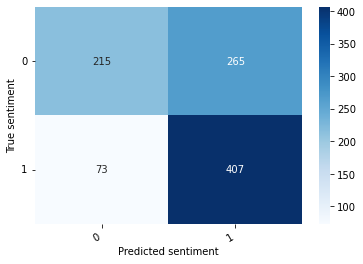

In [28]:
class_names = ['negative', 'positive']
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
hmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True sentiment')
plt.xlabel('Predicted sentiment');

In [29]:
accuracy_score(y_test, y_pred)

0.6479166666666667

In [30]:
metric_names = ['precision','recall','fscore','support']
metric_values = precision_recall_fscore_support(y_test, y_pred)
for i in range(0, len(metric_values)):
    print('{0}: {1}'.format(metric_names[i], metric_values[i]))
    


precision: [0.74652778 0.60565476]
recall: [0.44791667 0.84791667]
fscore: [0.55989583 0.70659722]
support: [480 480]


**Fitting Logistic regression on predicted and test data**

In [31]:
import statsmodels.api as stat
logit = stat.Logit(y_pred, y_test)
logit = logit.fit(disp=0)
print(logit.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  960
Model:                          Logit   Df Residuals:                      959
Method:                           MLE   Df Model:                            0
Date:                Sun, 04 Dec 2022   Pseudo R-squ.:                 0.08371
Time:                        18:53:55   Log-Likelihood:                -537.34
converged:                       True   LL-Null:                       -586.43
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sentiments     1.7184      0.127     13.519      0.000       1.469       1.967


In [32]:
logit.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sentiments     0.3256      0.014     22.793      0.000       0.298       0.354
==============================================================================
"""